In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams['figure.figsize'] = fig_size
from matplotlib import rc
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
import xgboost
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor


# Primera fase: Análisis
La fase de análisis se refiere al proceso crítico de realizar investigaciones iniciales sobre datos para descubrir patrones, detectar anomalías, probar hipótesis y verificar supuestos con la ayuda de estadísticas y representaciones gráficas. Nuestro objetivo es predecir el precio de inmuebles, dependiendo de todas las otras variables. El precio, en este caso, es nuestra variable dependiente, mientras que todas las demás características son variables independientes. 

## Obtención de datos de viviendas 
  El conjunto de datos utilizado en este proyecto proviene del dataset publicado en kaggle.com, llamado "House Sales in King County, USA". Este conjunto de datos contiene precios de venta de viviendas para el condado de King, que incluye Seattle, en Estados Unidos. Incluye casas vendidas entre mayo de 2014 y mayo de 2015.

In [2]:
df = pd.read_csv('Dataset/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Limpieza y análisis exploratorio inicial de los datos obtenidos
Después de haber recopilado toda la información, se analizarán y evaluarán los datos obtenidos para lograr elegir un subgrupo de datos para poder resolver el problema definido.

In [3]:
df.shape

(21613, 21)

In [4]:
#Tabla con los precios del dataset
precios = df['price']
precios.head()

0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

In [5]:
#Precio mínimo en el dataset
min_precio = np.amin(precios)
#Precio máximo en el dataset
max_precio = np.amax(precios)
#Media del precio en el dataset
media_precio = np.mean(precios)
#Mediana del precio en el dataset
mediana_precio = np.median(precios)
#Desviación estándar del precio en el dataset
std_precio = np.std(precios)

#Resultados
print("Resultados:")
print("Precio mínimo: ${}".format(min_precio))
print("Precio máximo: ${}".format(max_precio))
print("Media: ${}".format(media_precio))
print("Mediana: ${}".format(mediana_precio))
print("Desviación Estándar: ${}".format(std_precio))

Resultados:
Precio mínimo: $75000.0
Precio máximo: $7700000.0
Media: $540088.1417665294
Mediana: $450000.0
Desviación Estándar: $367118.7031813722


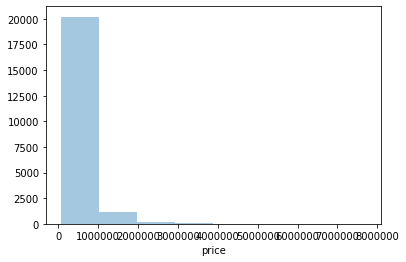

In [6]:
#Distribución del precio
sns.distplot(df['price'], kde=False, bins=8)

Como se puede observar, dicha variable presenta una distribución asimétrica, desviada de la normal. Podemos notar que la mayor parte de la densidad se encuentra dentro de los miles hasta 1 millon, con algunos pocos casos llegando a los 2 millones.

### Correlacion entre las variables y precio
Tener demasiadas funciones en un modelo no siempre es algo bueno porque puede causar un sobreajuste y resultados peores cuando queremos predecir valores para un nuevo conjunto de datos. Por lo tanto, si una característica no mejora mucho su modelo, no agregarlo puede ser una mejor opción.

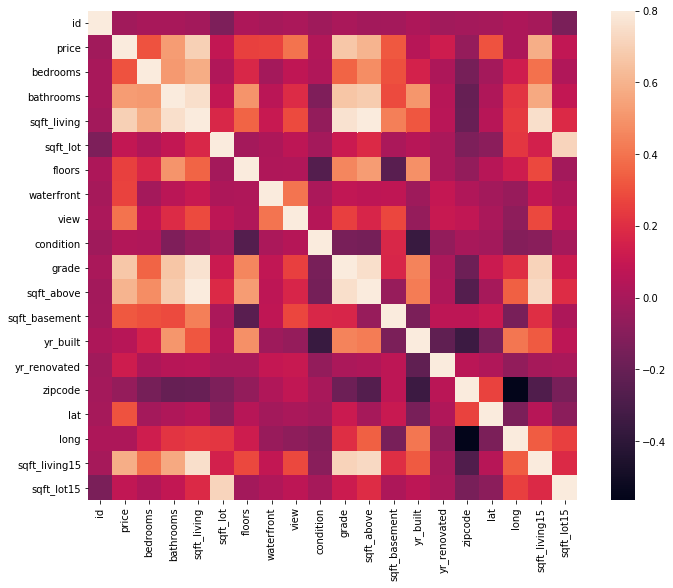

In [7]:
#Matriz de correlacion
matcorr = df.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(matcorr, vmax = .8, square = True)

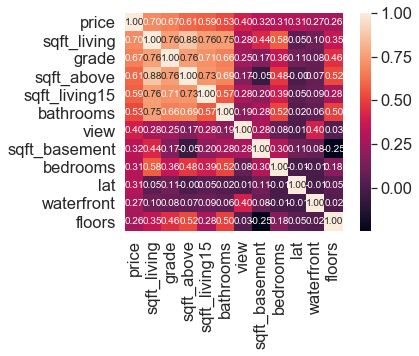

In [8]:
#Primeras 12 variables mas correlacionadas
n = 12 #numero de variables a utilizar para la matriz
col = matcorr.nlargest(n, 'price')['price'].index
cm = np.corrcoef(df[col].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm, annot = True, square = True, fmt = '.2f', annot_kws = {'size': 10}, yticklabels = col.values, xticklabels = col.values)
plt.show()

In [9]:
#Tabla con las variables mas correlacionadas con precio
mas_corr = pd.DataFrame(col)
mas_corr.columns = ['Variables mas correlacionadas']
mas_corr

,Variables mas correlacionadas
0,price
1,sqft_living
2,grade
3,sqft_above
4,sqft_living15
5,bathrooms
6,view
7,sqft_basement
8,bedrooms
9,lat


## 	Consolidación del dataset final para pruebas
Para el propósito del proyecto, el conjunto de datos se ha preprocesado de la siguiente manera:

In [10]:
#Buscando valores nulos en el dataset
nan_rows = df[df.isnull().any(1)]
nan_rows

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [12]:
#Dataset final a utilizar, con las 12 caracteristicas mas correlacionadas
dataset = df.copy().drop(['id', 'floors', 'date', 'sqft_lot', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15', 'condition'], axis = 1)
dataset.head()

,price,bedrooms,bathrooms,sqft_living,waterfront,view,grade,sqft_above,sqft_basement,yr_built,lat,long
0,221900.0,3,1.00,1180,0,0,7,1180,0,1955,47.5112,-122.257
1,538000.0,3,2.25,2570,0,0,7,2170,400,1951,47.7210,-122.319
2,180000.0,2,1.00,770,0,0,6,770,0,1933,47.7379,-122.233
3,604000.0,4,3.00,1960,0,0,7,1050,910,1965,47.5208,-122.393
4,510000.0,3,2.00,1680,0,0,8,1680,0,1987,47.6168,-122.045


## Análisis exploratorio exhaustivo del dataset final
Veremos y analizaremos las relaciones existentes entre el precio y las demás características de nuestro conjunto de datos final.

### Gráficos de dispersión

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


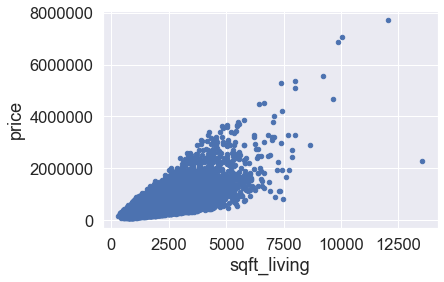

In [13]:
#Sqft_living vs precio
dataset.plot.scatter('sqft_living', 'price')

El grafico nos muestra como un espacio mas grande en la sala generalmente tiene un precio mas alto. Sin embargo podemos observar un caso donde casas "baratas" que ofrecen una gran sala de estar.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


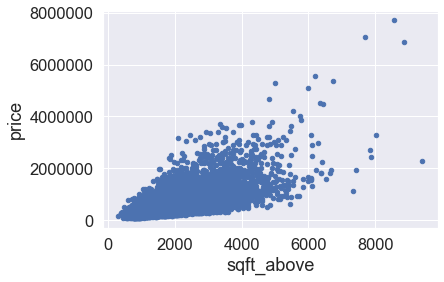

In [14]:
#Sqft_above vs precio
dataset.plot.scatter('sqft_above', 'price')

Tal como en el caso anterior se esperaba que una superficie habitable más grande significa un precio más alto. La grafica muestra que generalmente ese es el caso. Pero, de nuevo se pueden observar varias casas "baratas" que ofrecen una gran superificie por un precio bajo.

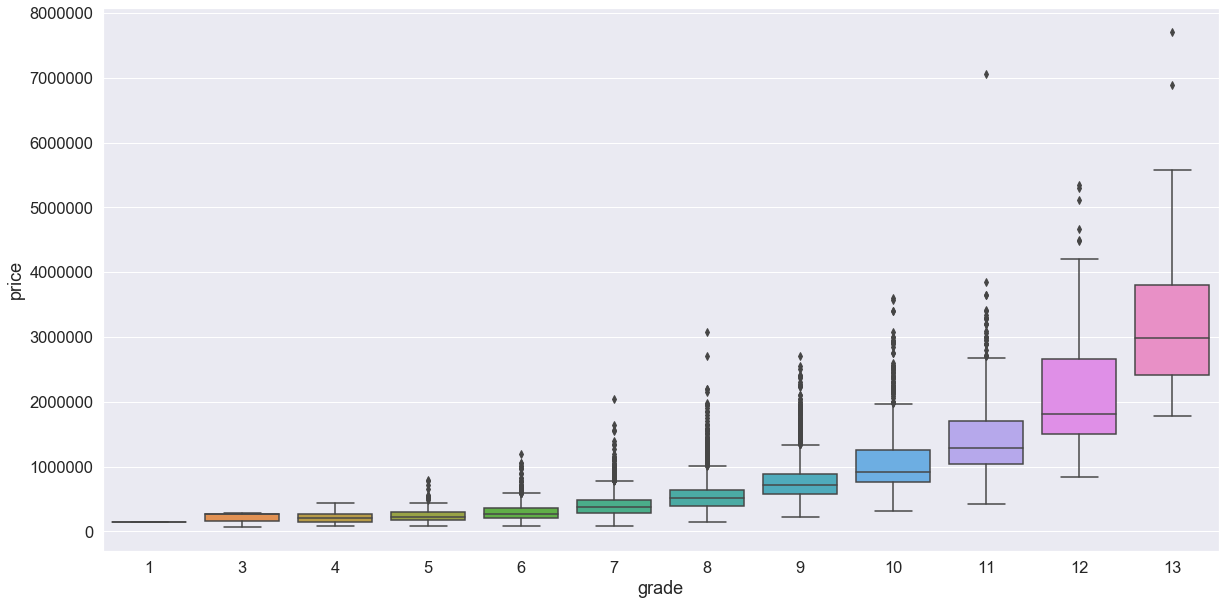

In [15]:
#Calificacion vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['grade'], y=dataset['price'])

De este grafico podemos concluir que un mejor grado lleva a un precio mas alto, sin embargo podemos notar varios valores atipicos en algunos casos con grados mas bajos. Esto explica la relación de correlación que existe entre estas dos variables ya que a pesar de los valores atípicos observados, el incremento medio de precio sigue una aproximación a una recta.

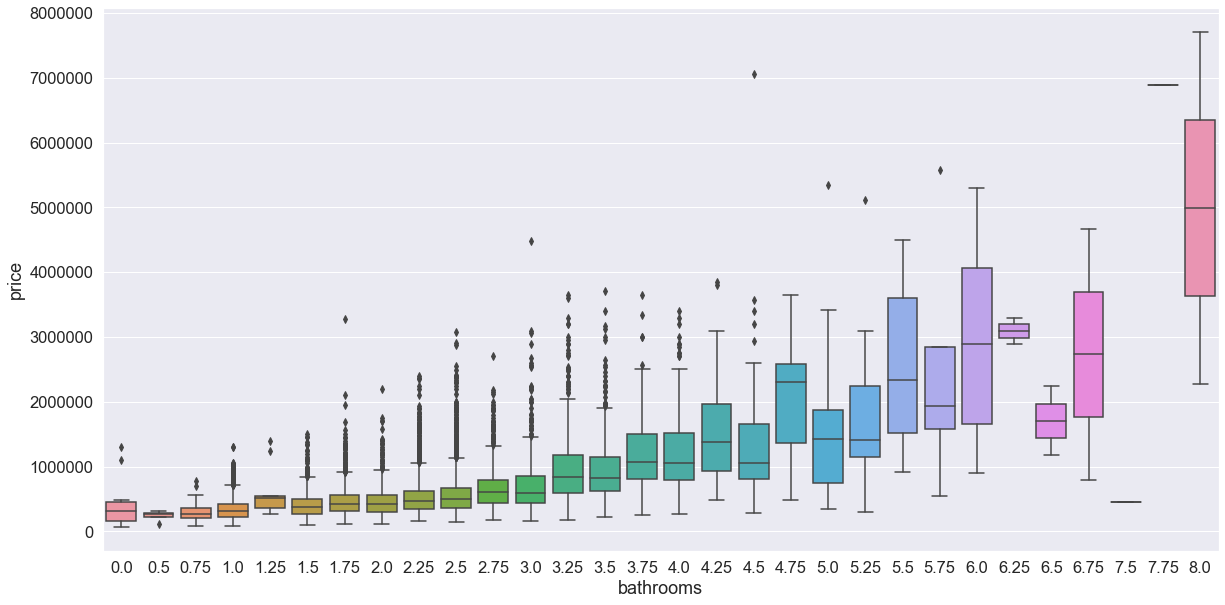

In [16]:
#Baños vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['bathrooms'], y=dataset['price'])

Podemos notar que existen un numero de valores atipicos en las viviendas que van desde 0 baños hasta 4.5 baños, y uno que otro valor entre 5 y 5.75. Tambien se puede observar que el mayor precio se encuentra en las viviendas que cuentan con 8 baños completos, lo cual es logico debido a que puede concluirse que son viviendas mas grandes que las que poseen menor numero de baños.

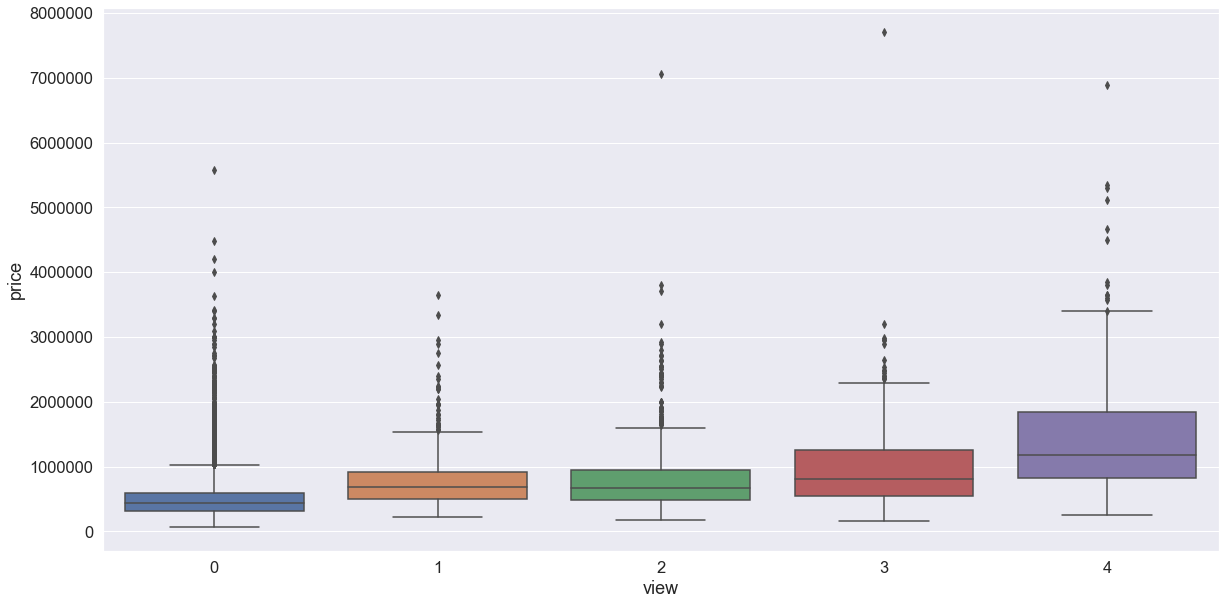

In [17]:
#Vista vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['view'], y=dataset['price'])

Se pueden observar varios valores atipicos en los 5 casos presentados en el dataset en cuanto a la vista de las casas,  diﬁcultando la comprensión de la variable desde el punto de vista de negocio. Desde el punto de vista de comprensión de negocio, lo lógico sería que a mejor vista, mayor fuera el precio de la vivienda.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


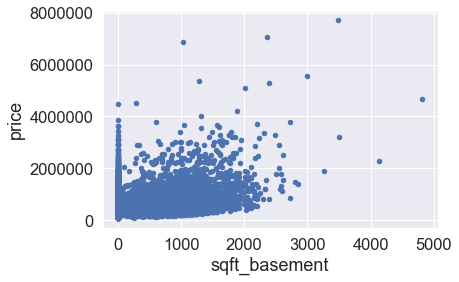

In [18]:
#Sqft_basement vs precio
dataset.plot.scatter('sqft_basement', 'price')

Se puede observar como los datos se encuentran acotados por dos rectas ﬁcticias. La primera de ellas partiendo del 0 correspondiente a las viviendas que no disponen de área de sótano. La segunda abarca la masa de datos desde abajo. Tambien, podemos observar que existen algunos valores atípicos que no guardan relación con el signiﬁcado de dicha variable.

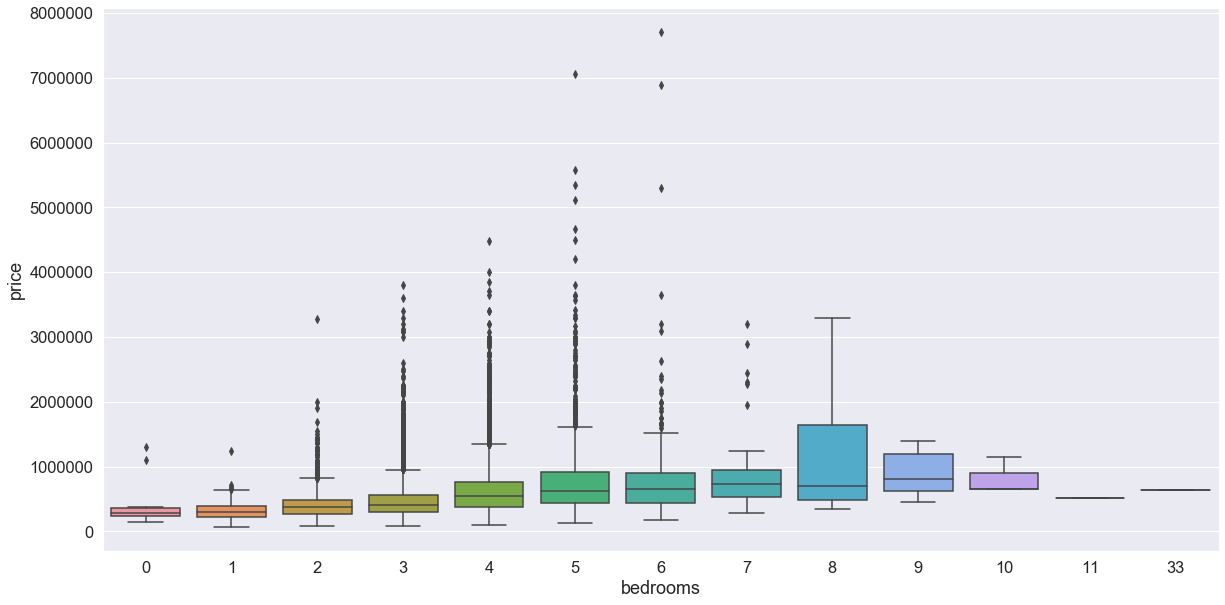

In [19]:
#Habitaciones vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['bedrooms'], y=dataset['price'])

Se aprecian gran cantidad de valores atípicos para las viviendas que poseen 0, 1, 2, 3, 4, 5, 6 y 7 habitaciones. Como se puede observar el incremento de habitaciones no proporciona una linealidad con respecto al precio de la vivienda. De hecho los precios de viviendas más caros se encuentran para las viviendas con 8 habitaciones, cuando en realidad deberían ser las de 10 siguiendo dicha relación de proporción.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


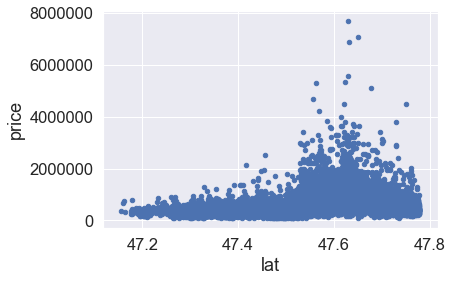

In [20]:
#Latitud vs precio
dataset.plot.scatter('lat', 'price')

De la relacion del precio con la latitud podemos observar como la gran mayoria de los valores se encuentran la parte de abajo, a excepcion de algunos valores atipicos que se posiciones en los precios mas altos. Tambien podemos ver que cuando aumenta un poco la latitud, los precios se elevan un poco.

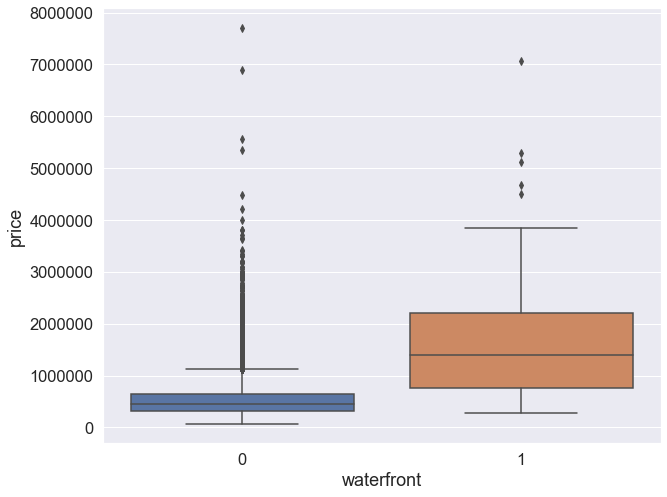

In [21]:
#Frente al mar vs precio
f, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x=dataset['waterfront'], y=dataset['price'])

Se puede notar la diferencia entre los precios para viviendas que se encuentran ubicadas frente al agua. Aquellas que poseen un vista al mar tienden a tener mayor precio, sin embargo podemos observar algunos valores atipicos donde viviendas sin vista al agua tienen precios mas altos.

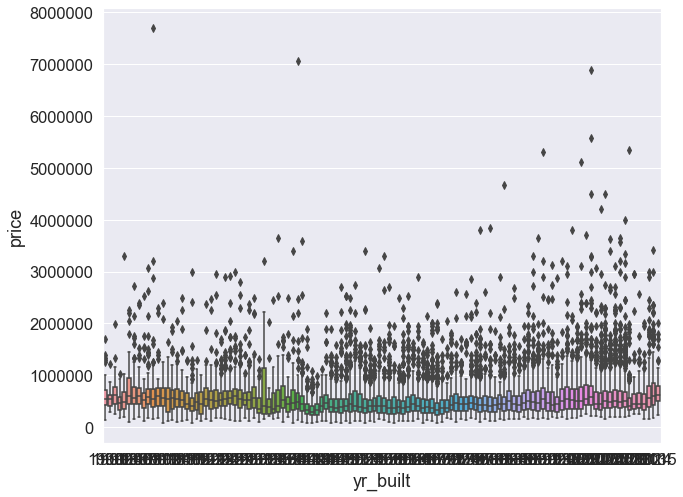

In [22]:
#Año de construcción vs precio
f, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x=dataset['yr_built'], y=dataset['price'])

En el grafico podemos observar un gran numero de valores atipicos en todos los casos de años de construccion, tambien podemos observar que los precios se mantienen relativamente constantes a lo largo de los años, notando un aumento al rededor del año 1930. Podemos observar tambien como a traves de los años los precios tienen a subir y bajar.

# Fase 2: Diseño

## Elaboración de hipótesis de trabajo en base del estudio exploratorio previo.

## Procesamiento de información y generación de características para modelado.

### División de los datos
Para esta sección tomaremos el conjunto de datos de vivienda y los dividiremos en subconjuntos de entrenamiento y evaluación. Por lo general, los datos también se mezclan en un orden aleatorio al crear los subconjuntos de entrenamiento y prueba para eliminar cualquier sesgo en el orden del conjunto de datos.

In [23]:
#Tabla que contiene las caracteristicas de los inmuebles, sin la variable dependiente, precio, la cual intentaremos predecir
carac = dataset.drop(['price'], axis = 1)
carac.head()

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,sqft_above,sqft_basement,yr_built,lat,long
0,3,1.00,1180,0,0,7,1180,0,1955,47.5112,-122.257
1,3,2.25,2570,0,0,7,2170,400,1951,47.7210,-122.319
2,2,1.00,770,0,0,6,770,0,1933,47.7379,-122.233
3,4,3.00,1960,0,0,7,1050,910,1965,47.5208,-122.393
4,3,2.00,1680,0,0,8,1680,0,1987,47.6168,-122.045


In [24]:
#Tabla que contiene los precios de los inmuebles en el dataset
precios = pd.DataFrame(dataset['price'])
precios.head()

,price
0,221900.0
1,538000.0
2,180000.0
3,604000.0
4,510000.0


In [25]:
#Division de las variables en entrenamiento y evaluacion
x_ent, x_eval, y_ent, y_eval = train_test_split(carac, precios, test_size=0.2)

# Fase 3: Implementación
En esta tercera sección del proyecto, desarrollaremos las herramientas y técnicas necesarias para que un modelo haga una predicción. 

## Generación de modelos predictivos utilizando machine learning.
Una vez que se limpian los datos, procederemos a realizar nuestros modelos de aprendizaje automático. El precio de venta es en dólares e intentaremos predecirlo.

### Regresión Lineal
En estadísticas, regresión lineal es una aproximación para modelar la relación entre una variable escalar dependiente "Y" y una o mas variables explicativas nombradas con "X". Lo que haremos es "dibujar una recta" que nos indicará la tendencia de un conjunto de datos continuos. 

In [26]:
lr = linear_model.LinearRegression()
modelo_1 = lr.fit(x_ent, y_ent)
print('Coeficientes: ', modelo_1.coef_)
print('Intersección: ', modelo_1.intercept_)

Coeficientes:  [[-3.46127820e+04  4.60339994e+04  1.16238224e+02  5.65663940e+05
   5.13955495e+04  1.00981890e+05  7.51635576e+01  4.10746665e+01
  -2.85308454e+03  5.56359670e+05 -1.02421541e+05]]
Intersección:  [-33972214.73267842]


In [27]:
prediccion_1 = modelo_1.predict(x_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( y_eval, prediccion_1)
rmse = np.sqrt(metrics.mean_squared_error(y_eval, prediccion_1))
r2 = metrics.r2_score(y_eval, prediccion_1)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 126073.4358817611
Error cuadrático medio: 195672.93223562255
R-cuadrado: 0.7150488614813604


In [28]:
#Tabla que contiene los resultados de las metricas de evaluacion de cada modelo
evaluacion = pd.DataFrame({'Modelo': [], 'Error medio absoluto':[], 'Error cuadrático medio':[], 'R-cuadrado':[],})
r = evaluacion.shape[0]
evaluacion.loc[r] = ['Regresion lineal', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)
evaluacion

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
0,Regresion lineal,126073.435882,195672.932236,0.715049


In [29]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_1.flatten()
valor_real = np.array(y_eval).flatten()

In [30]:
#Tabla de comparacion, conteniendo los valores reales y los obtenidos por el modelo
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,442500.0,535162.824484
1,318000.0,330592.604511
2,285000.0,175148.001051
3,680000.0,601109.848528
4,506000.0,474621.472622
...,...,...
4318,415000.0,388175.719926
4319,349950.0,307661.700152
4320,183500.0,42583.410036
4321,510000.0,606174.919408


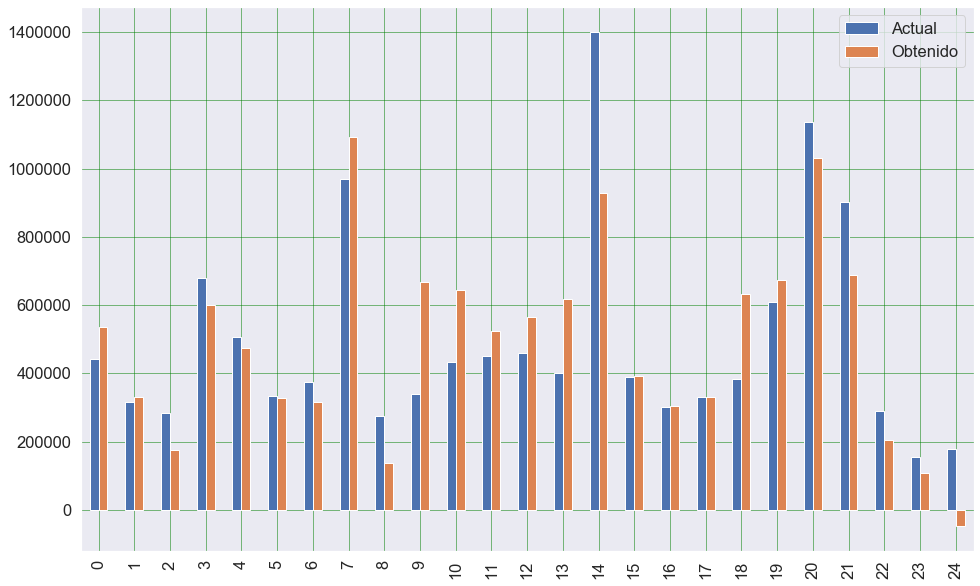

In [31]:
#Ahora graficaremos la diferencia observada entre dichos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Cross Validation y RFE
La validación cruzada (Cross Validation en ingles) es una técnica utilizada para evaluar modelos de ML mediante la capacitación de varios modelos en subconjuntos de datos de entrada disponibles y evaluándolos en el subconjunto complementario de datos, consiste en repetir y calcular la media aritmética obtenida de las medidas de evaluación sobre diferentes las particiones.
RFE o Eliminación de Características Recursivas consiste en la selección de características automáticamente de los datos que más contribuyen a la variable de predicción. Tener características irrelevantes en los datos puede disminuir la precisión de muchos modelos, especialmente los algoritmos lineales como la regresión lineal y logística.

#### RFE con 3 caracteristicas a elegir

In [32]:
#RFE
lr = linear_model.LinearRegression()
rfe = RFE(lr, n_features_to_select=3)

In [33]:
X = dataset.copy().drop(['price'], axis = 1)
Y = dataset['price']
modelo = rfe.fit(X, Y)

In [34]:
print(rfe.support_)
print(rfe.ranking_)

[False False False  True False  True False False False  True False]
[5 4 7 1 3 1 8 9 6 1 2]


In [35]:
print("Categorias ordenadas por su rango:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), dataset.columns)))

Categorias ordenadas por su rango:
[(1, 'sqft_living'), (1, 'view'), (1, 'yr_built'), (2, 'lat'), (3, 'waterfront'), (4, 'bedrooms'), (5, 'price'), (6, 'sqft_basement'), (7, 'bathrooms'), (8, 'grade'), (9, 'sqft_above')]


In [36]:
#Tenemos un nuevo arreglo x, con las columnas elegidas por el RFE
nueva_x = rfe.transform(X)
nueva_x

array([[ 0.    ,  7.    , 47.5112],
       [ 0.    ,  7.    , 47.721 ],
       [ 0.    ,  6.    , 47.7379],
       ...,
       [ 0.    ,  7.    , 47.5944],
       [ 0.    ,  8.    , 47.5345],
       [ 0.    ,  7.    , 47.5941]])

In [37]:
#Cross validation
puntuaciones = []
lr = linear_model.LinearRegression()
kf = KFold(n_splits = 5, shuffle = True)
for ent_index, eval_index in kf.split(nueva_x):
    print("Division de entrenamiento: ", ent_index)
    print("Division de evaluacion: ", eval_index)
    X_ent, X_eval, Y_ent, Y_eval = nueva_x[ent_index], nueva_x[eval_index], Y[ent_index], Y[eval_index]
    modelo_2 = lr.fit(X_ent, Y_ent)
    puntuaciones.append(lr.score(X_eval, Y_eval))

Division de entrenamiento:  [    0     3     4 ... 21607 21611 21612]
Division de evaluacion:  [    1     2     5 ... 21608 21609 21610]
Division de entrenamiento:  [    0     1     2 ... 21610 21611 21612]
Division de evaluacion:  [    4    10    25 ... 21570 21589 21592]
Division de entrenamiento:  [    0     1     2 ... 21608 21609 21610]
Division de evaluacion:  [    3     6    20 ... 21598 21611 21612]
Division de entrenamiento:  [    0     1     2 ... 21610 21611 21612]
Division de evaluacion:  [    7     9    11 ... 21579 21602 21606]
Division de entrenamiento:  [    1     2     3 ... 21610 21611 21612]
Division de evaluacion:  [    0    26    29 ... 21603 21604 21607]


In [38]:
print('Puntaciones: ', puntuaciones)
print('Promedio de las puntaciones', np.mean(puntuaciones))

Puntaciones:  [0.5215112445722698, 0.561872692871667, 0.5308010430655161, 0.5630170951253509, 0.5553832997051429]
Promedio de las puntaciones 0.5465170750679893


In [39]:
prediccion_2 = modelo_2.predict(X_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( Y_eval, prediccion_2)
rmse = np.sqrt(metrics.mean_squared_error(Y_eval, prediccion_2))
r2 = metrics.r2_score(Y_eval, prediccion_2)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 152017.55090124445
Error cuadrático medio: 249270.48610059233
R-cuadrado: 0.5553832997051429


In [40]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['RFE con Cross Validation (3)', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
0,Regresion lineal,126073.435882,195672.932236,0.715049
1,RFE con Cross Validation (3),152017.550901,249270.486101,0.555383


In [41]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_2.flatten()
valor_real = np.array(Y_eval).flatten()

In [42]:
#Tabla de comparacion, conteniendo los valores reales y los obtenidos por el modelo
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,221900.0,374450.577644
1,937000.0,649175.099031
2,719000.0,693188.915165
3,640000.0,669420.173119
4,240000.0,260988.469385
...,...,...
4317,1575000.0,988421.331420
4318,467000.0,686141.579249
4319,507250.0,585300.608950
4320,429000.0,605161.282897


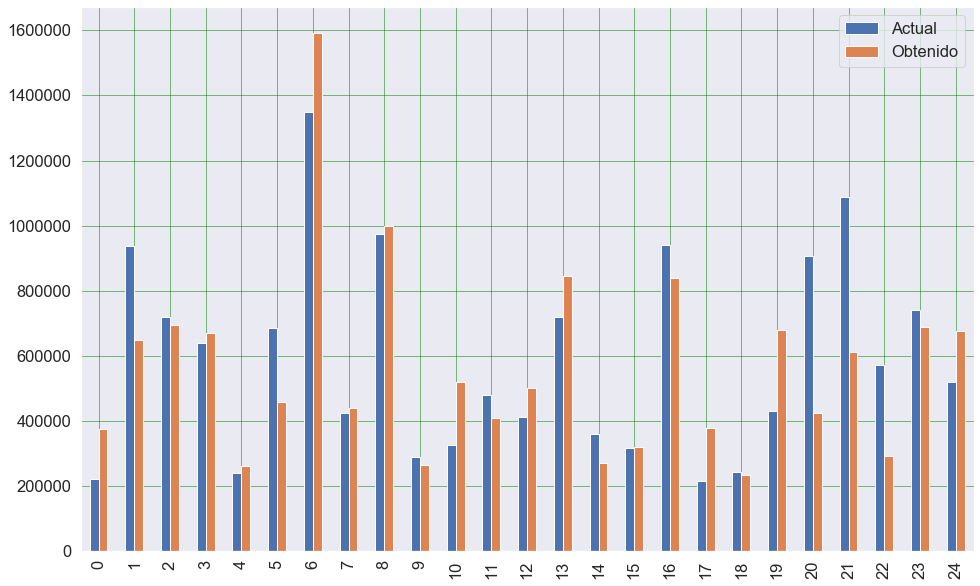

In [43]:
#Ahora graficaremos la diferencia observada entre dichos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#### RFE con 5 caracteristicas a elegir

In [44]:
#RFE
lr = linear_model.LinearRegression()
rfe_2 = RFE(lr, n_features_to_select=5)

In [45]:
X = dataset.copy().drop(['price'], axis = 1)
Y = dataset['price']
modelo = rfe_2.fit(X, Y)

In [46]:
print(rfe_2.support_)
print(rfe_2.ranking_)

[False False False  True  True  True False False False  True  True]
[3 2 5 1 1 1 6 7 4 1 1]


In [47]:
print("Categorias ordenadas por su rango:")
print(sorted(zip(map(lambda x: round(x, 4), rfe_2.ranking_), dataset.columns)))

Categorias ordenadas por su rango:
[(1, 'lat'), (1, 'sqft_living'), (1, 'view'), (1, 'waterfront'), (1, 'yr_built'), (2, 'bedrooms'), (3, 'price'), (4, 'sqft_basement'), (5, 'bathrooms'), (6, 'grade'), (7, 'sqft_above')]


In [48]:
#Tenemos un nuevo arreglo x, con las columnas elegidas por el RFE
nueva_x = rfe_2.transform(X)
nueva_x

array([[   0.    ,    0.    ,    7.    ,   47.5112, -122.257 ],
       [   0.    ,    0.    ,    7.    ,   47.721 , -122.319 ],
       [   0.    ,    0.    ,    6.    ,   47.7379, -122.233 ],
       ...,
       [   0.    ,    0.    ,    7.    ,   47.5944, -122.299 ],
       [   0.    ,    0.    ,    8.    ,   47.5345, -122.069 ],
       [   0.    ,    0.    ,    7.    ,   47.5941, -122.299 ]])

In [49]:
#Cross validation
puntuaciones = []
lr = linear_model.LinearRegression()
kf = KFold(n_splits = 5, shuffle = True)
for ent_index, eval_index in kf.split(nueva_x):
    print("Division de entrenamiento: ", ent_index)
    print("Division de evaluacion: ", eval_index)
    X_ent, X_eval, Y_ent, Y_eval = nueva_x[ent_index], nueva_x[eval_index], Y[ent_index], Y[eval_index]
    modelo_3 = lr.fit(X_ent, Y_ent)
    puntuaciones.append(lr.score(X_eval, Y_eval))

Division de entrenamiento:  [    1     2     3 ... 21610 21611 21612]
Division de evaluacion:  [    0     4     5 ... 21604 21605 21606]
Division de entrenamiento:  [    0     2     4 ... 21610 21611 21612]
Division de evaluacion:  [    1     3    12 ... 21597 21600 21608]
Division de entrenamiento:  [    0     1     2 ... 21609 21610 21612]
Division de evaluacion:  [    8    24    32 ... 21595 21603 21611]
Division de entrenamiento:  [    0     1     2 ... 21610 21611 21612]
Division de evaluacion:  [   10    13    15 ... 21592 21607 21609]
Division de entrenamiento:  [    0     1     3 ... 21608 21609 21611]
Division de evaluacion:  [    2     6     7 ... 21602 21610 21612]


In [50]:
print('Puntaciones: ', puntuaciones)
print('Promedio de las puntaciones', np.mean(puntuaciones))

Puntaciones:  [0.586518332659498, 0.5855010891638623, 0.5622267283081583, 0.5886241486042139, 0.5622388038176893]
Promedio de las puntaciones 0.5770218205106843


In [51]:
prediccion_3 = modelo_3.predict(X_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( Y_eval, prediccion_3)
rmse = np.sqrt(metrics.mean_squared_error(Y_eval, prediccion_3))
r2 = metrics.r2_score(Y_eval, prediccion_3)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 150144.8447049555
Error cuadrático medio: 253738.92405628308
R-cuadrado: 0.5622388038176893


In [52]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['RFE con Cross Validation (5)', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
0,Regresion lineal,126073.435882,195672.932236,0.715049
2,RFE con Cross Validation (5),150144.844705,253738.924056,0.562239
1,RFE con Cross Validation (3),152017.550901,249270.486101,0.555383


In [53]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_3.flatten()
valor_real = np.array(Y_eval).flatten()

In [54]:
#Tabla de comparacion, contiendo los valores reales y los obtenidos por el modelo
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,180000.0,322630.686503
1,257500.0,252108.399697
2,291850.0,312346.056419
3,468000.0,482854.131801
4,485000.0,473022.549217
...,...,...
4317,541800.0,768810.787083
4318,467000.0,672822.358850
4319,224000.0,32378.288937
4320,402101.0,424647.516829


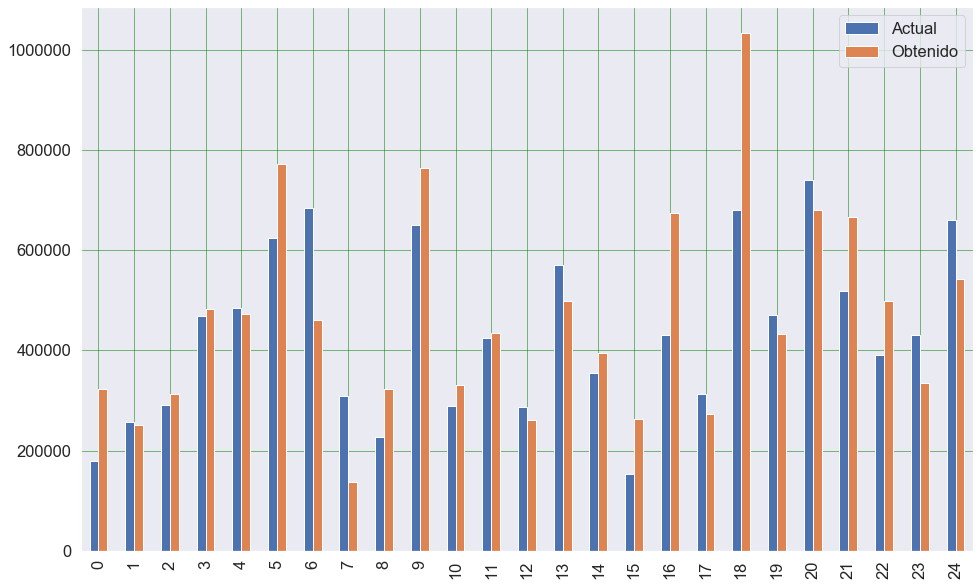

In [55]:
#Ahora graficaremos la diferencia observada entre cihos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#### RFE con 7 caracteristicas a elegir

In [56]:
#RFE
lr = linear_model.LinearRegression()
rfe_3 = RFE(lr, n_features_to_select=7)

In [57]:
X = dataset.copy().drop(['price'], axis = 1)
Y = dataset['price']
modelo = rfe_3.fit(X, Y)

In [58]:
print(rfe_3.support_)
print(rfe_3.ranking_)

[ True  True False  True  True  True False False False  True  True]
[1 1 3 1 1 1 4 5 2 1 1]


In [59]:
print("Categorias ordenadas por su rango:")
print(sorted(zip(map(lambda x: round(x, 4), rfe_3.ranking_), dataset.columns)))

Categorias ordenadas por su rango:
[(1, 'bedrooms'), (1, 'lat'), (1, 'price'), (1, 'sqft_living'), (1, 'view'), (1, 'waterfront'), (1, 'yr_built'), (2, 'sqft_basement'), (3, 'bathrooms'), (4, 'grade'), (5, 'sqft_above')]


In [60]:
#Tenemos un nuevo arreglo x, con las columnas elegidas por el RFE
nueva_x = rfe_3.transform(X)
nueva_x

array([[   3.    ,    1.    ,    0.    , ...,    7.    ,   47.5112,
        -122.257 ],
       [   3.    ,    2.25  ,    0.    , ...,    7.    ,   47.721 ,
        -122.319 ],
       [   2.    ,    1.    ,    0.    , ...,    6.    ,   47.7379,
        -122.233 ],
       ...,
       [   2.    ,    0.75  ,    0.    , ...,    7.    ,   47.5944,
        -122.299 ],
       [   3.    ,    2.5   ,    0.    , ...,    8.    ,   47.5345,
        -122.069 ],
       [   2.    ,    0.75  ,    0.    , ...,    7.    ,   47.5941,
        -122.299 ]])

In [61]:
#Cross validation
puntuaciones = []
lr = linear_model.LinearRegression()
kf = KFold(n_splits = 5, shuffle = True)
for ent_index, eval_index in kf.split(nueva_x):
    print("Division de entrenamiento: ", ent_index)
    print("Division de evaluacion: ", eval_index)
    X_ent, X_eval, Y_ent, Y_eval = nueva_x[ent_index], nueva_x[eval_index], Y[ent_index], Y[eval_index]
    modelo_4 = lr.fit(X_ent, Y_ent)
    puntuaciones.append(lr.score(X_eval, Y_eval))

Division de entrenamiento:  [    0     1     2 ... 21608 21609 21610]
Division de evaluacion:  [   13    19    24 ... 21606 21611 21612]
Division de entrenamiento:  [    0     1     2 ... 21610 21611 21612]
Division de evaluacion:  [    8     9    30 ... 21605 21608 21609]
Division de entrenamiento:  [    0     1     2 ... 21609 21611 21612]
Division de evaluacion:  [    3     5     6 ... 21596 21603 21610]
Division de entrenamiento:  [    1     2     3 ... 21610 21611 21612]
Division de evaluacion:  [    0    11    12 ... 21597 21602 21604]
Division de entrenamiento:  [    0     3     5 ... 21610 21611 21612]
Division de evaluacion:  [    1     2     4 ... 21594 21595 21607]


In [62]:
print('Puntaciones: ', puntuaciones)
print('Promedio de las puntaciones', np.mean(puntuaciones))

Puntaciones:  [0.6129301136607227, 0.5916686484403165, 0.5964973904607698, 0.584702491300054, 0.5908721287863123]
Promedio de las puntaciones 0.595334154529635


In [63]:
prediccion_4 = modelo_4.predict(X_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( Y_eval, prediccion_4)
rmse = np.sqrt(metrics.mean_squared_error(Y_eval, prediccion_4))
r2 = metrics.r2_score(Y_eval, prediccion_4)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 146417.02869622502
Error cuadrático medio: 228460.6722545649
R-cuadrado: 0.5908721287863123


In [64]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['RFE con Cross Validation (7)', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
0,Regresion lineal,126073.435882,195672.932236,0.715049
3,RFE con Cross Validation (7),146417.028696,228460.672255,0.590872
2,RFE con Cross Validation (5),150144.844705,253738.924056,0.562239
1,RFE con Cross Validation (3),152017.550901,249270.486101,0.555383


In [65]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_4.flatten()
valor_real = np.array(Y_eval).flatten()

In [66]:
#Tabla de comparacion, conteniendo los valores reales y los obtenidos por el modelo
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,538000.0,535762.832549
1,180000.0,275045.699660
2,510000.0,561034.241876
3,291850.0,285824.564552
4,530000.0,546069.238138
...,...,...
4317,347500.0,415894.908154
4318,572000.0,588820.300021
4319,350000.0,488660.225696
4320,520000.0,624720.641399


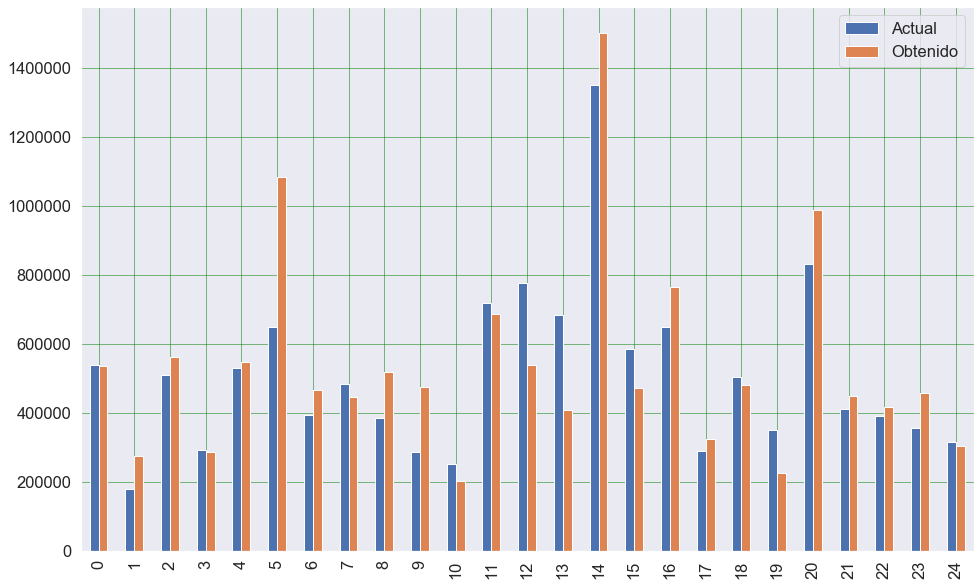

In [67]:
#Ahora graficaremos la diferencia observada entre dichos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Gradient Boosting
Gradient boosting o Potenciación del gradiente, es una técnica de aprendizaje automático utilizado para el análisis de la regresión y para problemas de clasificación estadística, el cual produce un modelo predictivo en forma de un conjunto de modelos de predicción débiles, típicamente árboles de decisión. Puede ser interpretado como un algoritmo de optimización en una función de coste adecuada

In [68]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [69]:
xgb.fit(x_ent,y_ent)

[17:09:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [70]:
prediccion_5 = xgb.predict(x_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( y_eval, prediccion_5)
rmse = np.sqrt(metrics.mean_squared_error(y_eval, prediccion_5))
r2 = metrics.r2_score(y_eval, prediccion_5)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 70256.83810794009
Error cuadrático medio: 126197.15987269055
R-cuadrado: 0.8814755217262966


In [71]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['XGBoost', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
4,XGBoost,70256.838108,126197.159873,0.881476
0,Regresion lineal,126073.435882,195672.932236,0.715049
3,RFE con Cross Validation (7),146417.028696,228460.672255,0.590872
2,RFE con Cross Validation (5),150144.844705,253738.924056,0.562239
1,RFE con Cross Validation (3),152017.550901,249270.486101,0.555383


In [72]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_5.flatten()
valor_real = np.array(y_eval).flatten()

In [73]:
#Tabla de comparacion, conteniendo los valores reales y los obtenidos por el modelos
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,442500.0,436044.81250
1,318000.0,272778.62500
2,285000.0,298059.87500
3,680000.0,658617.87500
4,506000.0,510673.40625
...,...,...
4318,415000.0,417481.28125
4319,349950.0,425290.81250
4320,183500.0,192965.65625
4321,510000.0,671603.43750


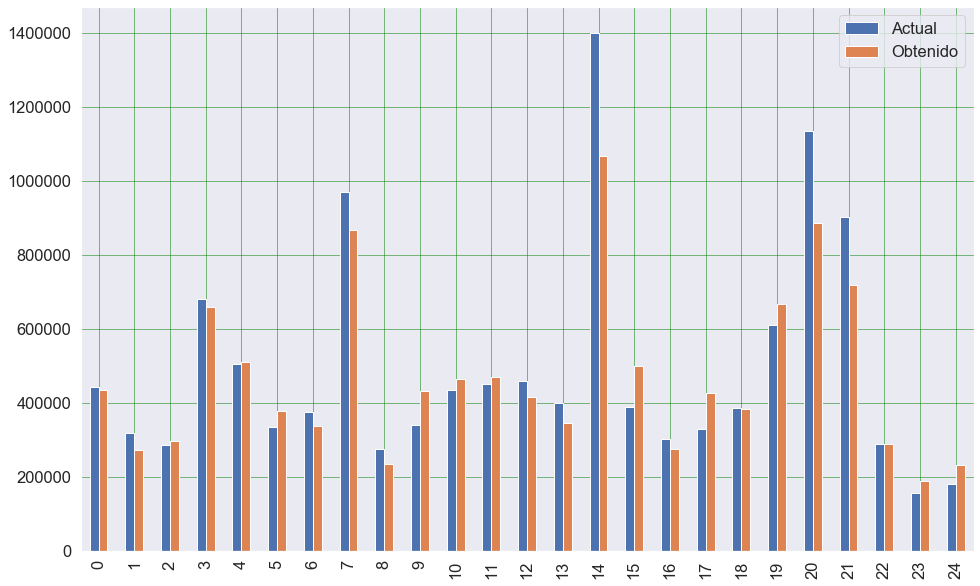

In [74]:
#Ahora graficaremos la diferencia observada entre dichos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Regresion Polinomial
La regresión polinómica es una forma de regresión lineal en la que la relación entre la variable independiente x y la variable dependiente y se modela como un polinomio de enésimo grado.

In [75]:
poly = PolynomialFeatures(degree=2)
X_entp = poly.fit_transform(x_ent)
X_evalp = poly.fit_transform(x_eval)
lr = linear_model.LinearRegression().fit(X_entp, y_ent)

In [76]:
prediccion_6 = lr.predict(X_evalp)
#Métricas de evaluación
mae = metrics.mean_absolute_error( y_eval, prediccion_6)
rmse = np.sqrt(metrics.mean_squared_error(y_eval, prediccion_6))
r2 = metrics.r2_score(y_eval, prediccion_6)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 108759.23411282516
Error cuadrático medio: 170607.38261098848
R-cuadrado: 0.7833770175979955


In [77]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['Regresion Polinomial', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
4,XGBoost,70256.838108,126197.159873,0.881476
5,Regresion Polinomial,108759.234113,170607.382611,0.783377
0,Regresion lineal,126073.435882,195672.932236,0.715049
3,RFE con Cross Validation (7),146417.028696,228460.672255,0.590872
2,RFE con Cross Validation (5),150144.844705,253738.924056,0.562239
1,RFE con Cross Validation (3),152017.550901,249270.486101,0.555383


In [78]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_6.flatten()
valor_real = np.array(y_eval).flatten()

In [79]:
#Tabla de comparacion, conteniendo los valores reales y los obtenidos por el modelo
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,442500.0,502790.286080
1,318000.0,385461.158929
2,285000.0,324176.609518
3,680000.0,545121.598567
4,506000.0,449539.739030
...,...,...
4318,415000.0,391021.750602
4319,349950.0,371551.446521
4320,183500.0,91386.958057
4321,510000.0,506927.961337


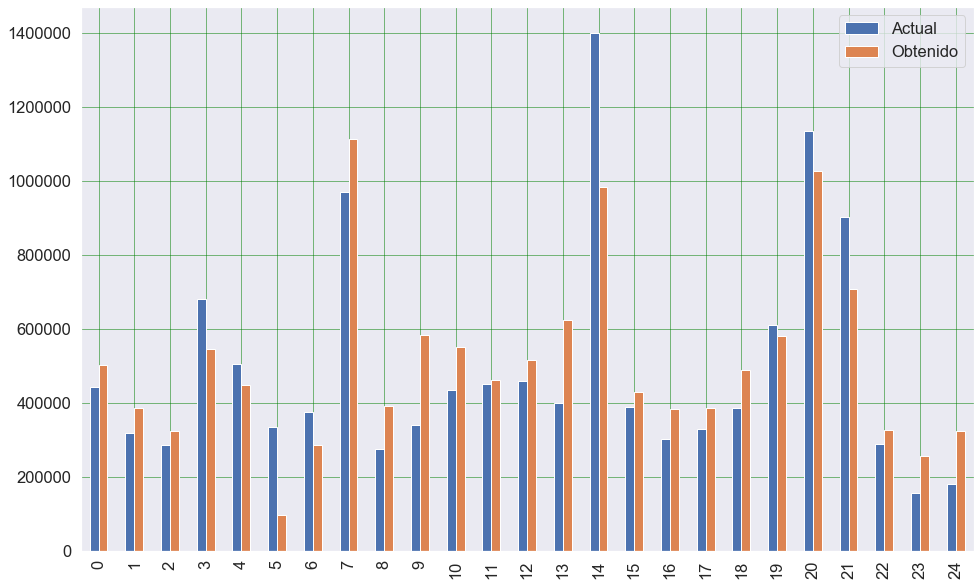

In [80]:
#Ahora graficaremos la diferencia observada entre dichos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Random Forest Regressor
Los bosques aleatorios o los bosques de decisión aleatorios son un método de aprendizaje para la clasificación, la regresión y otras tareas que operan construyendo una multitud de árboles de decisión en el momento del entrenamiento y generan asi la predicción media (regresión) de los árboles individuales. Los bosques de decisión aleatorios corrigen el hábito de los árboles de decisión de adaptarse demasiado a su conjunto de entrenamiento.

In [81]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0) 
regressor.fit(x_ent, y_ent) 

C:\Users\mavil\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [82]:
prediccion_7 = regressor.predict(x_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( y_eval, prediccion_7)
rmse = np.sqrt(metrics.mean_squared_error(y_eval, prediccion_7))
r2 = metrics.r2_score(y_eval, prediccion_7)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 73257.54974680832
Error cuadrático medio: 143824.78264669812
R-cuadrado: 0.8460511875896922


In [83]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['Bosques Aleatorios', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
4,XGBoost,70256.838108,126197.159873,0.881476
6,Bosques Aleatorios,73257.549747,143824.782647,0.846051
5,Regresion Polinomial,108759.234113,170607.382611,0.783377
0,Regresion lineal,126073.435882,195672.932236,0.715049
3,RFE con Cross Validation (7),146417.028696,228460.672255,0.590872
2,RFE con Cross Validation (5),150144.844705,253738.924056,0.562239
1,RFE con Cross Validation (3),152017.550901,249270.486101,0.555383


In [84]:
#Vamos a visualizar ahora la diferencia entre los valores obtenidos por nuestro modelo y los valores reales del dataset
valor_pred = prediccion_7.flatten()
valor_real = np.array(y_eval).flatten()

In [85]:
#Tabla de comparacion, conteniendo los valores reales y los obtenidos por el modelo
d = pd.DataFrame({'Actual': valor_real, 'Obtenido': valor_pred})
d

,Actual,Obtenido
0,442500.0,503364.090000
1,318000.0,288996.500000
2,285000.0,290678.500000
3,680000.0,679551.390000
4,506000.0,482825.040000
...,...,...
4318,415000.0,378377.600000
4319,349950.0,387072.300000
4320,183500.0,181141.850000
4321,510000.0,712203.833333


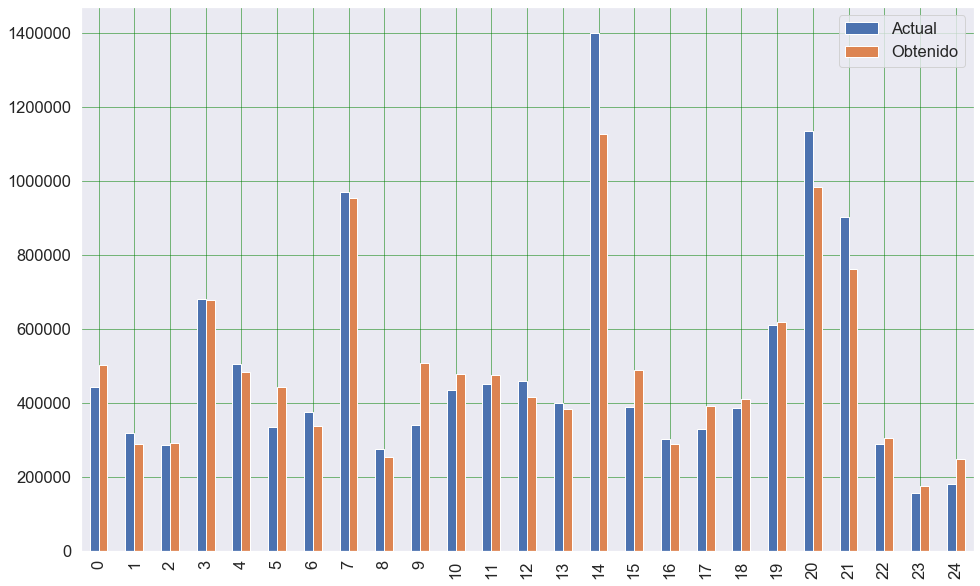

In [86]:
#Ahora graficaremos la diferencia observada entre dichos valores
df1 = d.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()